# DDPM: Denoising Diffusion Probabilistic Models — Forward & Reverse Process (MNIST)

**Definition (short):** A DDPM gradually corrupts data $x_0$ with Gaussian noise through a forward diffusion (Markov) process $q$ to obtain $x_1, \dots, x_T$. A learned reverse process $p_\theta$ then denoises step-by-step from $x_T$ back to $x_0$.

**Forward (diffusion) process:** for $t=1,\dots,T$:

$ q(x_t \mid x_{t-1}) = \mathcal{N}\big(x_t; \sqrt{1-\beta_t}\, x_{t-1}, \; \beta_t I\big), $

with noise schedule $0 < \beta_1 \le \beta_2 \le \dots \le \beta_T < 1$.

**Closed-form marginal:** we can sample $x_t$ directly from $x_0$:

$ q(x_t \mid x_0) = \mathcal{N}\big(x_t; \sqrt{\bar\alpha_t}\, x_0,\; (1-\bar\alpha_t) I\big), $

where $\alpha_t = 1 - \beta_t$ and $\bar\alpha_t = \prod_{s=1}^t \alpha_s$.

**Reverse (denoising) process (learned):**

We parameterize

$ p_\theta(x_{t-1} \mid x_t) = \mathcal{N}\big(x_{t-1}; \mu_\theta(x_t,t), \; \Sigma_\theta(x_t,t)\big). $

Ho et al. (DDPM) show we can predict the noise $\epsilon_\theta(x_t,t)$ and use a fixed variance to get $\mu_\theta$ via known algebra.

**Training objective (simplified / equivalent):** learn $\epsilon_\theta$ to minimize

$ \mathbb{E}_{x_0,\epsilon,t} \big[ \lVert \epsilon - \epsilon_\theta(x_t, t) \rVert^2 \big] $

where $x_t = \sqrt{\bar\alpha_t}\, x_0 + \sqrt{1-\bar\alpha_t}\, \epsilon$.

**What this notebook will do (step-by-step):**

1. Show the noise schedule and plot $\beta_t$, $\bar\alpha_t$ (2D/3D plots).  
2. Simulate forward process on MNIST images and show trajectories $x_0 \to x_T$ (grids).  
3. Derive and compute the posterior $q(x_{t-1}\mid x_t, x_0)$ and print the analytic mean/var for examples.  
4. Build a small U-Net-like denoiser (lightweight) that predicts noise $\epsilon_\theta(x_t,t)$; train for a few epochs (demo) while printing per-batch computation.  
5. Run the learned reverse sampling from pure Gaussian $x_T$ and show denoising trajectory grids.  
6. Visualize and explain every step so you can *see* how the math maps to computations and visuals.

*Run the notebook on a machine with PyTorch; GPU is recommended but not required.*  
(Training in this demo is short — increase epochs for high-quality samples.)


In [5]:
# Cell 2 — imports and configuration
# Run this first

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt
import numpy as np
import math
import os
from tqdm import tqdm

# reproducibility
torch.manual_seed(0)
np.random.seed(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# Config
cfg = {
    "batch_size": 128,
    "lr": 2e-4,
    "epochs": 3,           # demo; increase to 50+ for quality
    "img_size": 28,
    "T": 100,              # number of diffusion steps (small for demo; can use 1000 in papers)
    "beta_schedule": "linear",  # 'linear' or 'cosine' placeholder
    "save_dir": "./ddpm_demo",
    "seed": 0
}
os.makedirs(cfg["save_dir"], exist_ok=True)
print("Config:", cfg)


Device: cuda
Config: {'batch_size': 128, 'lr': 0.0002, 'epochs': 3, 'img_size': 28, 'T': 100, 'beta_schedule': 'linear', 'save_dir': './ddpm_demo', 'seed': 0}


Computed schedules (showing first 8 values):
betas[:8]: [0.0001     0.00030101 0.00050202 0.00070303 0.00090404 0.00110505
 0.00130606 0.00150707]
alphas_cumprod[:8]: [0.9999     0.99959904 0.99909717 0.9983948  0.9974922  0.99638987
 0.9950885  0.99358886]
sqrt_alphas_cumprod[:8]: [0.99995    0.9997995  0.9995485  0.99919707 0.9987453  0.9981933
 0.99754125 0.9967893 ]


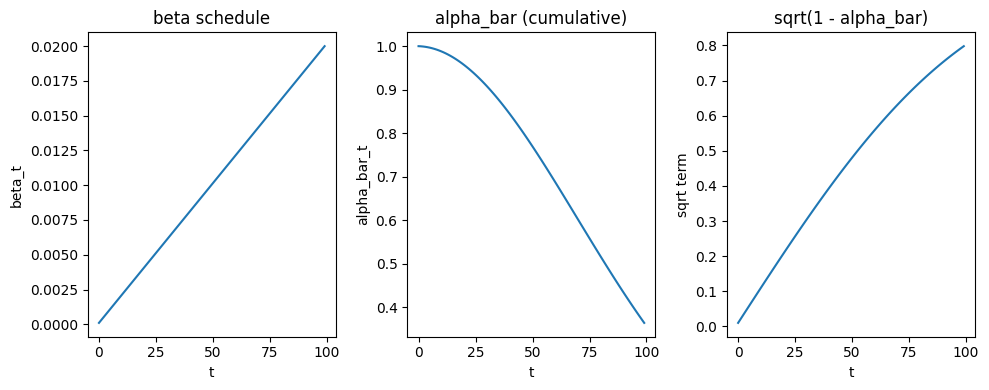

In [6]:
# Cell 3 — helper functions: schedules, forward q(x_t|x_0), plotting tools
# Run this cell second

# Noise schedule: linear beta as demo
def linear_beta_schedule(T, beta_start=1e-4, beta_end=2e-2):
    return torch.linspace(beta_start, beta_end, T)

def cosine_beta_schedule(T, s=0.008):
    # from Nichol & Dhariwal (slightly modified); optional
    steps = T + 1
    t = torch.linspace(0, T, steps) / T
    alphas_cumprod = torch.cos(((t + s) / (1 + s)) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.999)

T = cfg["T"]
if cfg["beta_schedule"] == "linear":
    betas = linear_beta_schedule(T)
else:
    betas = cosine_beta_schedule(T)
betas = betas.to(device)

alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)          # \bar\alpha_t
alphas_cumprod_prev = torch.cat([torch.tensor([1.0], device=device), alphas_cumprod[:-1]], dim=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)

print("Computed schedules (showing first 8 values):")
print("betas[:8]:", betas[:8].cpu().numpy())
print("alphas_cumprod[:8]:", alphas_cumprod[:8].cpu().numpy())
print("sqrt_alphas_cumprod[:8]:", sqrt_alphas_cumprod[:8].cpu().numpy())

# utility: sample x_t from x_0 using closed form
def q_sample(x0, t, noise=None):
    """
    x0: tensor (B,C,H,W) with values in [-1,1] or [0,1] depending on convention.
    t: integer tensor (B,) in [0, T-1] (index)
    returns x_t sampled from q(x_t | x_0)
    """
    if noise is None:
        noise = torch.randn_like(x0)
    # gather sqrt_alpha_cumprod and sqrt_one_minus for each batch element
    sqrt_ac = sqrt_alphas_cumprod[t].view(-1, 1, 1, 1)
    sqrt_omac = sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1)
    return sqrt_ac * x0 + sqrt_omac * noise

# plotting helpers
def show_image_grid(x, nrow=8, title=None):
    # x: tensor (N, C, H, W) in [0,1] or [-1,1] as needed
    grid = utils.make_grid(x.cpu(), nrow=nrow, normalize=True, value_range=(0,1))
    plt.figure(figsize=(6,6))
    plt.imshow(grid.permute(1,2,0).squeeze(), cmap='gray' if grid.shape[0]==1 else None)
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

# Visualize schedules (2D plot and 3D surface of sqrt alpha cumprod vs t)
plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.plot(betas.cpu().numpy(), label='beta_t')
plt.title('beta schedule')
plt.xlabel('t'); plt.ylabel('beta_t')

plt.subplot(1,3,2)
plt.plot(alphas_cumprod.cpu().numpy(), label='alpha_bar_t')
plt.title('alpha_bar (cumulative)')
plt.xlabel('t'); plt.ylabel('alpha_bar_t')

plt.subplot(1,3,3)
plt.plot(sqrt_one_minus_alphas_cumprod.cpu().numpy(), label='sqrt(1-alpha_bar)')
plt.title('sqrt(1 - alpha_bar)')
plt.xlabel('t'); plt.ylabel('sqrt term')

plt.tight_layout()
plt.show()


100%|██████████| 9.91M/9.91M [00:00<00:00, 20.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 487kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 15.4MB/s]


Sampled a batch of MNIST images. Showing original (x0).


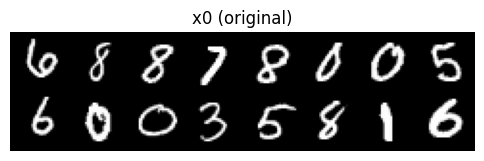

Timesteps to show: [0, 10, 25, 50, 75, 99]
t=0: mean pixel value (xt) = -0.7183, std = 0.6362
t=10: mean pixel value (xt) = -0.7138, std = 0.6416
t=25: mean pixel value (xt) = -0.6901, std = 0.6626
t=50: mean pixel value (xt) = -0.6323, std = 0.7380
t=75: mean pixel value (xt) = -0.5294, std = 0.8230
t=99: mean pixel value (xt) = -0.4298, std = 0.8816


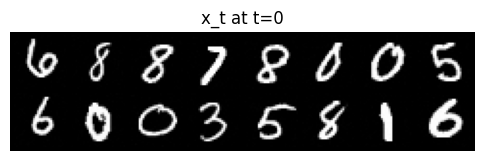

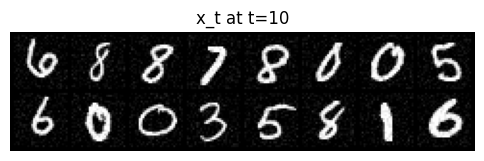

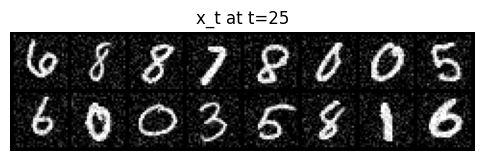

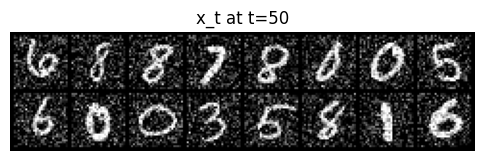

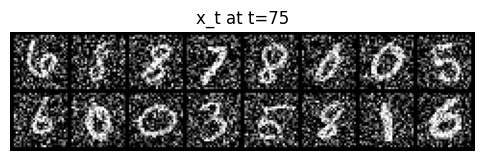

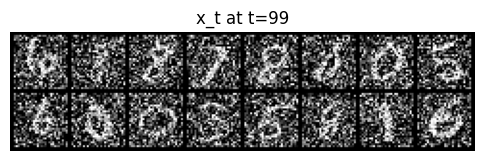

In [7]:
# Cell 4 — Forward diffusion demo: load MNIST, corrupt a few images across timesteps, and plot
# Run this after Cell 3

# Load MNIST (normalized to [0,1]; we'll rescale to [-1,1] for diffusion)
transform = transforms.Compose([transforms.ToTensor()])
mnist = datasets.MNIST(root="./data", download=True, train=True, transform=transform)
loader = DataLoader(mnist, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)

# Take one batch
x_batch, y_batch = next(iter(loader))
# convert to float tensor in [-1,1] for better visual symmetry
x_batch = x_batch * 2.0 - 1.0  # in [-1,1]

print("Sampled a batch of MNIST images. Showing original (x0).")
show_image_grid((x_batch + 1.0)/2.0, nrow=8, title="x0 (original)")

# Choose timesteps to visualize (spread across T)
timesteps = [0, int(T*0.1), int(T*0.25), int(T*0.5), int(T*0.75), T-1]
timesteps = sorted(list(set([min(max(0,t), T-1) for t in timesteps])))
print("Timesteps to show:", timesteps)

# For each timestep, sample x_t from x0 and show
x0 = x_batch.to(device)
fig_imgs = []
for t in timesteps:
    t_tensor = torch.tensor([t]*x0.shape[0], device=device, dtype=torch.long)
    xt = q_sample(x0, t_tensor)  # uses different noise per sample
    fig_imgs.append(((xt + 1.0)/2.0).cpu())  # convert to [0,1] for display
    print(f"t={t}: mean pixel value (xt) = {xt.mean().item():.4f}, std = {xt.std().item():.4f}")

# Show grids for each timestep
for i, t in enumerate(timesteps):
    show_image_grid(fig_imgs[i], nrow=8, title=f"x_t at t={t}")



**Posterior closed form (used in many derivations):**

For the forward step
$ q(x_t \mid x_{t-1}) = \mathcal{N}\big(x_t; \sqrt{\alpha_t}\, x_{t-1}, \beta_t I\big) $,

the posterior given $x_0$ (and $x_t$) is also Gaussian:

$ q(x_{t-1} \mid x_t, x_0) = \mathcal{N}\big(x_{t-1}; \tilde{\mu}_t(x_t, x_0), \; \tilde{\beta}_t I \big) $

with
$ \tilde{\mu}_t = \frac{\sqrt{\bar\alpha_{t-1}}\beta_t}{1-\bar\alpha_t} x_0 + \frac{\sqrt{\alpha_t}(1-\bar\alpha_{t-1})}{1-\bar\alpha_t} x_t $

and

$ \tilde{\beta}_t = \frac{1-\bar\alpha_{t-1}}{1-\bar\alpha_t} \beta_t $.

(We will compute these numerically for a few example images.)


Using one example x0 (single image) for posterior computation demonstration.
t=25 scalars:
beta_t: 0.005125252529978752  alpha_t: 0.9948747754096985
alpha_cum_t: 0.9342166185379028  alpha_cum_t_prev: 0.939029335975647
coef_x0: 0.0754985585808754  coef_xt: 0.9244617223739624  tilde_beta_t: 0.0047502885572612286
tilde_mu_t mean pixel: -0.693450927734375 std: 0.6508991122245789
tilde_var_t (scalar): 0.0047502885572612286


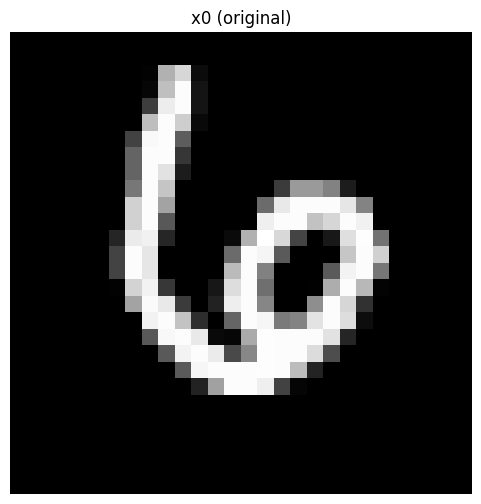

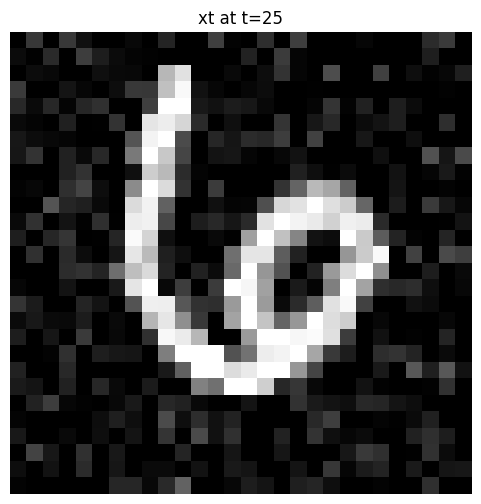

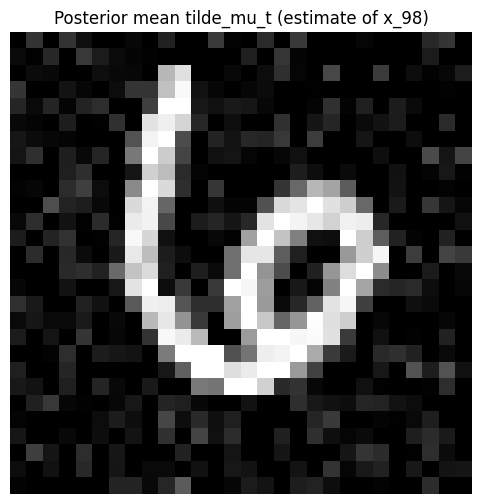

In [8]:
# Cell 5 — Analytic posterior q(x_{t-1} | x_t, x_0) and compute its mean/var for examples
# Run after Cell 4

# Derivation reminder (markdown printed here using $...$)
from IPython.display import Markdown, display
display(Markdown(r"""
**Posterior closed form (used in many derivations):**

For the forward step
$ q(x_t \mid x_{t-1}) = \mathcal{N}\big(x_t; \sqrt{\alpha_t}\, x_{t-1}, \beta_t I\big) $,

the posterior given $x_0$ (and $x_t$) is also Gaussian:

$ q(x_{t-1} \mid x_t, x_0) = \mathcal{N}\big(x_{t-1}; \tilde{\mu}_t(x_t, x_0), \; \tilde{\beta}_t I \big) $

with
$ \tilde{\mu}_t = \frac{\sqrt{\bar\alpha_{t-1}}\beta_t}{1-\bar\alpha_t} x_0 + \frac{\sqrt{\alpha_t}(1-\bar\alpha_{t-1})}{1-\bar\alpha_t} x_t $

and

$ \tilde{\beta}_t = \frac{1-\bar\alpha_{t-1}}{1-\bar\alpha_t} \beta_t $.

(We will compute these numerically for a few example images.)
"""))

# pick one image x0 from earlier batch (index 0)
x0_example = x0[0:1]  # shape (1,1,28,28)
print("Using one example x0 (single image) for posterior computation demonstration.")

# choose a timestep t>0
t_example = max(1, T//4)
t_idx = torch.tensor([t_example], device=device, dtype=torch.long)

# sample a specific xt from x0 using fixed rng (for reproducibility)
noise = torch.randn_like(x0_example)
xt_example = q_sample(x0_example, t_idx, noise=noise)

# Now compute posterior parameters tilde_mu_t and tilde_beta_t
# gather scalar values
beta_t = betas[t_example]
alpha_t = alphas[t_example]
alpha_cum_t = alphas_cumprod[t_example]
alpha_cum_t_prev = alphas_cumprod_prev[t_example]

# compute coefficients (scalars)
coef_x0 = (torch.sqrt(alpha_cum_t_prev) * beta_t) / (1.0 - alpha_cum_t)
coef_xt = (torch.sqrt(alpha_t) * (1.0 - alpha_cum_t_prev)) / (1.0 - alpha_cum_t)
tilde_beta_t = ((1.0 - alpha_cum_t_prev) / (1.0 - alpha_cum_t)) * beta_t

print(f"t={t_example} scalars:")
print("beta_t:", beta_t.item(), " alpha_t:", alpha_t.item())
print("alpha_cum_t:", alpha_cum_t.item(), " alpha_cum_t_prev:", alpha_cum_t_prev.item())
print("coef_x0:", coef_x0.item(), " coef_xt:", coef_xt.item(), " tilde_beta_t:", tilde_beta_t.item())

# compute tilde_mu_t as image tensors
tilde_mu_t = coef_x0.view(1,1,1,1) * x0_example + coef_xt.view(1,1,1,1) * xt_example
tilde_var_t = tilde_beta_t  # isotropic

# print some pixel stats and show images
print("tilde_mu_t mean pixel:", tilde_mu_t.mean().item(), "std:", tilde_mu_t.std().item())
print("tilde_var_t (scalar):", tilde_var_t.item())

# Show x0, xt, and the posterior mean (tilde_mu_t)
show_image_grid((x0_example + 1.0)/2.0, nrow=1, title="x0 (original)")
show_image_grid(((xt_example + 1.0)/2.0).cpu(), nrow=1, title=f"xt at t={t_example}")
show_image_grid(((tilde_mu_t + 1.0)/2.0).cpu(), nrow=1, title=f"Posterior mean tilde_mu_t (estimate of x_{t-1})")


In [9]:
# Cell 6 — small denoiser model (predict noise) and training loop (short demo)
# Run after Cell 5

# We'll implement a tiny UNet-style or simple CNN that takes x_t and timestep embedding t and predicts noise epsilon
class SimpleTimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, t):
        # t : tensor shape (B,) with integers in [0,T-1]
        # simple sinusoidal embedding (like positional encoding)
        half = self.dim // 2
        emb = torch.exp(torch.arange(half, device=t.device) * -math.log(10000) / half)
        emb = t[:, None].float() * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
        return emb  # (B, dim)

class TinyDenoiser(nn.Module):
    def __init__(self, time_emb_dim=32):
        super().__init__()
        self.time_mlp = nn.Sequential(
            SimpleTimeEmbedding(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )
        # small conv net
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 1, 3, padding=1),
        )
        # concatenate time embedding via channel-wise additive broadcast
        self.time_proj = nn.Linear(time_emb_dim, 28*28)  # to add as bias per pixel (simple trick)

    def forward(self, x, t):
        # x: (B,1,28,28), t: (B,)
        B = x.shape[0]
        temb = self.time_mlp(t)  # (B, D)
        # add time embedding as bias per pixel
        bias = self.time_proj(temb).view(B, 1, 28, 28)
        out = self.net(x) + bias
        return out  # predicted noise epsilon

# instantiate model
model = TinyDenoiser(time_emb_dim=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=cfg["lr"])
mse = nn.MSELoss()

# Demo training loop: we train to predict epsilon given x_t and t where x_t = sqrt_alpha_bar * x0 + sqrt(1-alpha_bar) * eps
train_loader = DataLoader(mnist, batch_size=cfg["batch_size"], shuffle=True, num_workers=2, pin_memory=True)

print("Starting quick training demo for denoiser (few epochs). Each training step prints shapes and loss for the first batch of epoch 1.")
model.train()
for epoch in range(1, cfg["epochs"]+1):
    epoch_loss = 0.0
    pbar = tqdm(train_loader, total=len(train_loader))
    for batch_idx, (xb, _) in enumerate(pbar):
        xb = xb.to(device) * 2.0 - 1.0  # to [-1,1]
        B = xb.size(0)
        t = torch.randint(0, T, (B,), device=device).long()
        eps = torch.randn_like(xb)
        # generate xt via closed form
        xt = q_sample(xb, t, noise=eps)
        # predict noise
        eps_pred = model(xt, t)
        loss = mse(eps_pred, eps)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        if epoch == 1 and batch_idx == 0:
            print("DETAILED STEP PRINT (epoch 1, first batch):")
            print("xb shape:", xb.shape, " t shape:", t.shape, " eps shape:", eps.shape)
            print("xt shape:", xt.shape, " eps_pred shape:", eps_pred.shape)
            print("loss (MSE) example:", loss.item())
        pbar.set_description(f"Epoch {epoch} loss {loss.item():.4f}")
    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch} average MSE loss: {avg_loss:.6f}")
    # save demo checkpoint
    torch.save(model.state_dict(), os.path.join(cfg["save_dir"], f"denoiser_ep{epoch}.pth"))
print("Quick training demo finished. For better results, increase epochs and model capacity.")


Starting quick training demo for denoiser (few epochs). Each training step prints shapes and loss for the first batch of epoch 1.


Epoch 1 loss 0.9268:   1%|▏         | 7/469 [00:01<01:15,  6.11it/s]

DETAILED STEP PRINT (epoch 1, first batch):
xb shape: torch.Size([128, 1, 28, 28])  t shape: torch.Size([128])  eps shape: torch.Size([128, 1, 28, 28])
xt shape: torch.Size([128, 1, 28, 28])  eps_pred shape: torch.Size([128, 1, 28, 28])
loss (MSE) example: 1.0178804397583008


Epoch 1 loss 0.1968: 100%|██████████| 469/469 [00:09<00:00, 48.12it/s]


Epoch 1 average MSE loss: 0.290540


Epoch 2 loss 0.1413: 100%|██████████| 469/469 [00:09<00:00, 50.80it/s]


Epoch 2 average MSE loss: 0.150241


Epoch 3 loss 0.1265: 100%|██████████| 469/469 [00:09<00:00, 51.08it/s]

Epoch 3 average MSE loss: 0.131065
Quick training demo finished. For better results, increase epochs and model capacity.


Display timesteps: [0, 2, 5, 10, 30, 60, 99]
t=99: mean 0.0065, std 0.9906, posterior_var 0.019767
t=60: mean -0.1068, std 0.8878, posterior_var 0.011832
t=30: mean -0.2189, std 0.7930, posterior_var 0.005758
t=10: mean -0.2869, std 0.7323, posterior_var 0.001746
t=5: mean -0.3049, std 0.7212, posterior_var 0.000768
t=2: mean -0.3142, std 0.7175, posterior_var 0.000223
t=0: mean -0.3189, std 0.7158, posterior_var 0.000000


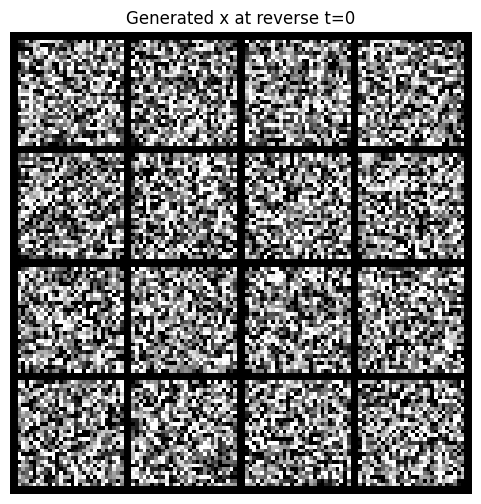

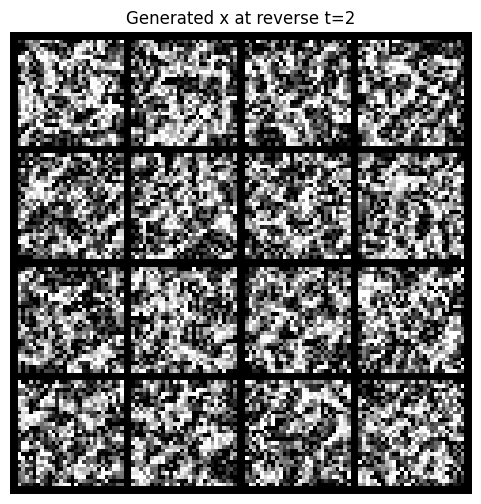

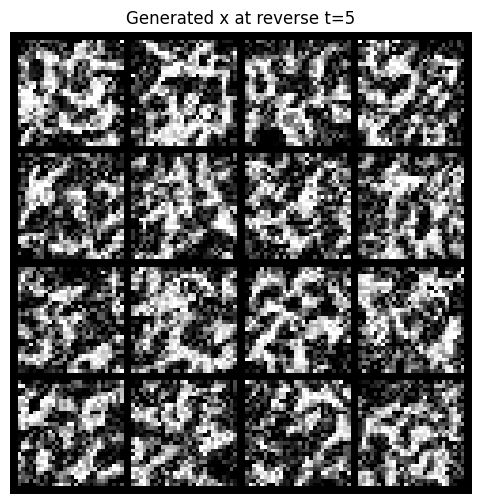

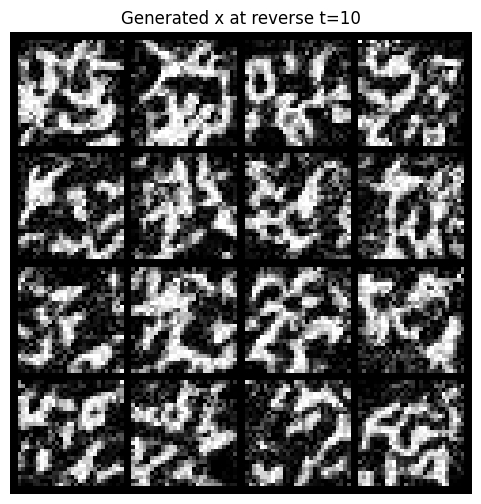

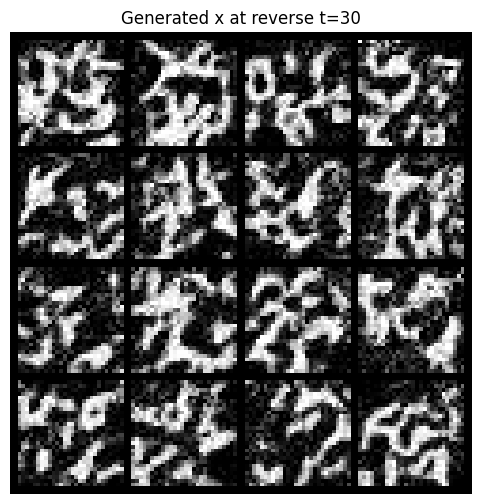

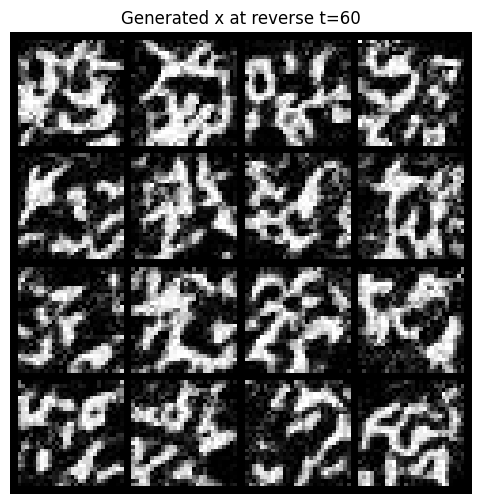

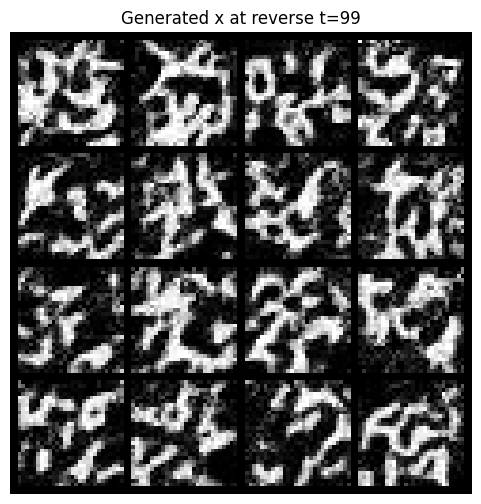

Reverse sampling completed (demo). Generated images are initial proof-of-concept — increase model capacity & training time for better samples.


In [10]:
# Cell 7 — Reverse sampling (ancestral) using learned epsilon predictor; visualize denoising trajectory
# Run after Cell 6

model.eval()
with torch.no_grad():
    # start from pure Gaussian x_T
    n_samples = 16
    x_t = torch.randn(n_samples, 1, cfg["img_size"], cfg["img_size"], device=device)  # x_T ~ N(0, I)
    imgs_traj = []  # will store images at selected timesteps for visualization

    # choose checkpoints to display (linearly spaced)
    display_steps = list(sorted(set([0, int(T*0.02), int(T*0.05), int(T*0.1), int(T*0.3), int(T*0.6), T-1])))
    print("Display timesteps:", display_steps)

    for t_inv in reversed(range(T)):
        t = torch.tensor([t_inv]*n_samples, device=device, dtype=torch.long)
        # predict noise
        eps_pred = model(x_t, t)
        # compute model's mean \mu_\theta (according to DDPM algebra)
        beta_t = betas[t_inv]
        sqrt_alpha_t = torch.sqrt(alphas[t_inv])
        sqrt_one_minus_alpha_cum_t = torch.sqrt(1.0 - alphas_cumprod[t_inv])
        coef1 = 1.0 / torch.sqrt(alphas[t_inv])
        # From Ho et al., a common formula for predicted x0:
        x0_pred = (x_t - sqrt_one_minus_alpha_cum_t * eps_pred) / sqrt_alphas_cumprod[t_inv]
        # compute mean of p_theta(x_{t-1} | x_t)
        # simplified version: mu_theta = ... (we use standard DDPM reparam)
        posterior_mean = (
            (torch.sqrt(alphas_cumprod_prev[t_inv]) * betas[t_inv] / (1.0 - alphas_cumprod[t_inv])) * x0_pred
            + (torch.sqrt(alphas[t_inv]) * (1.0 - alphas_cumprod_prev[t_inv]) / (1.0 - alphas_cumprod[t_inv])) * x_t
        )
        # compute posterior variance tilde_beta_t
        posterior_var = ((1.0 - alphas_cumprod_prev[t_inv]) / (1.0 - alphas_cumprod[t_inv])) * betas[t_inv]
        # sample x_{t-1}
        if t_inv > 0:
            noise = torch.randn_like(x_t)
            x_t = posterior_mean + torch.sqrt(posterior_var) * noise
        else:
            x_t = posterior_mean  # at t=0 take mean (deterministic)
        # store images at checkpoints
        if t_inv in display_steps:
            imgs_traj.append(((x_t + 1.0) / 2.0).clamp(0,1).cpu())
            print(f"t={t_inv}: mean {x_t.mean().item():.4f}, std {x_t.std().item():.4f}, posterior_var {posterior_var.item():.6f}")

# show grids for each stored timestep
for i, t in enumerate(sorted(display_steps)):
    show_image_grid(imgs_traj[i], nrow=4, title=f"Generated x at reverse t={t}")

print("Reverse sampling completed (demo). Generated images are initial proof-of-concept — increase model capacity & training time for better samples.")


# Summary & Practical Tips

**What we covered (with $...$ math):**

- **Forward process:** $ q(x_t \mid x_{t-1}) = \mathcal{N}(x_t; \sqrt{1-\beta_t}\, x_{t-1}, \beta_t I) $.  
- **Closed-form marginal:** $ q(x_t \mid x_0) = \mathcal{N}(x_t; \sqrt{\bar\alpha_t}\, x_0, (1-\bar\alpha_t)I) $.  
- **Posterior:** $ q(x_{t-1}\mid x_t,x_0) $ has analytic mean $\tilde\mu_t(x_t,x_0)$ and variance $\tilde\beta_t$ (we computed and visualized them).  
- **Training objective (practical):** train $\epsilon_\theta$ to predict noise via $ \mathbb{E}_{x_0,\epsilon,t}[\lVert \epsilon - \epsilon_\theta(x_t,t)\rVert^2] $.  
- **Reverse sampling:** use predicted $\epsilon_\theta$ to compute $x_{t-1}$ from $x_t$ iteratively (ancestral sampling).

**Notes & tips:**
- This notebook is pedagogical and demonstrates all key formulae, computations, and visuals. The denoiser used here is intentionally small — for strong sample quality use larger U-Nets and longer training (many epochs, larger datasets, classifier-free guidance, etc.).  
- Use $T\ge1000$ with carefully tuned schedules in production usage; for demos $T=100$ is common.  
- For stable training follow the DDPM paper: normalize data to $[-1,1]$, use Adam, learning-rate schedules, gradient norm clipping, and long training.  
- Extensions: conditional DDPMs (class-conditional), improved noise schedules, variance learning, and score-based diffusion.

If you want, next I can:
1. Produce a downloadable `.ipynb` file with these cells.  
2. Replace the TinyDenoiser with a compact U-Net (ready for longer training).  
3. Show a GIF animation of the denoising trajectory (reverse) for a single sample.  

Which follow-up would you like?
